In [35]:
#import necessary packages

import numpy as np
import sys
import elephant

import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../FC_scripts/')
import assembly_util # class for handling spike sorted outputs 

#import importlib
#importlib.reload(assembly_util)

<module 'assembly_util' from '../FC_scripts/assembly_util.py'>

In [2]:
#read-in example spike train
data_path = '../data/example_spktrain.npy'

spk_data = np.load(data_path, allow_pickle=True).item() 
spk_data.keys() # dictionary with two keys 

dict_keys(['spktimes', 'spktemps'])

'spktimes' stores spike times (ms.) of all spikes in the network 
'spktemps' stores template id (neuron id) for each spike 

In [3]:
spktimes = spk_data['spktimes'] # spike times of all neurons (ms.)
spktemps = spk_data['spktemps'] # matching neuron id for each spike

In [4]:
print(spktimes) # for this snippet, the start time was 12000014 (ms.) and the end time was 13199999.8 (ms.)

[12000014.   12000017.05 12000027.25 ... 13199999.5  13199999.7
 13199999.8 ]


In [5]:
rec_dur = np.max(spktimes)-np.min(spktimes)
print(rec_dur/1000/60) # recording duration of 20 min.

19.999763333333348


In [36]:
# set up Spiketrain class

spkclass = assembly_util.Spiketrain(spktimes, spktemps)

spkclass.set_trains() # sorts and separates spike times for each neuron

print('number of neurons : ' + str(len(spkclass.spktime_list))) # spktime_list is a list that stores spike times of each neuron.  
print(spkclass.uniq_ids) # uniq_ids corresponds to the id generated from the spike-sorting

number of neurons : 40
[  2   4   7  10  17  19  21  41  46  49  51  52  54  55  57  59  60  69
  71  72  77  78  80  82  83  90  91  94  98  99 102 108 114 121 133 138
 140 152 154 157]


## 1. derive functional connectivity from pearson correlation coefficient (PCC)


generate surrogate trains (shuffle spike times while keeping inter-spike intervals)

In [5]:
shuf_trains=spkclass.shuffle_trains(3) # for this example, we generate only 3 shuffled instantiations (ISI-preserved)
print(str(len(shuf_trains)) + ' instantiations')  # 3 instantiations

3 instantiations


then, we compute pairwise PCCs from both experimental and surrogate trains.

In [8]:
import warnings; warnings.simplefilter('ignore') # there will be a lot of warning msg. due to rounding of spike times 
PCC_FC_mat = spkclass.get_corr_mat(shuf_trains, 20, n_cpu=16) # This function does the job, we use a bin size of 20 ms.

done computing PCC FC mat


In [9]:
print(PCC_FC_mat['corr_mat_eff'].keys()) 
# 'p_val_mat' stores p-value like values for each edge. In the current work, it is not used as we only considered values that are always greater than the surrogate values.
# 'masked_corr' stores PCC values obtained from experimental data as-it-is but discarded spurious connections
# 'masked_eff' stores surrogate-corrected PCC values.
# 'raw_corr_mat' stores PCC values without any correction.

dict_keys(['p_val_mat', 'masked_corr', 'masked_eff', 'raw_corr_mat'])


(([], []), ([], []))

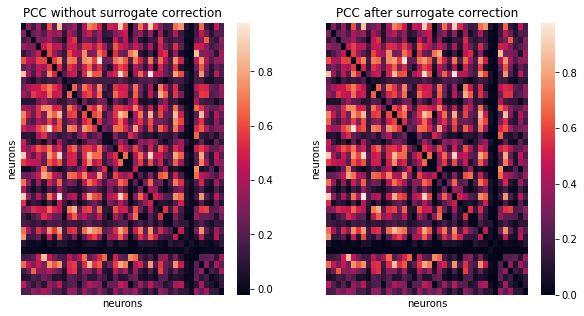

In [108]:
# plot 

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
sns.heatmap(PCC_FC_mat['corr_mat_eff']['raw_corr_mat'], ax=ax1)
ax1.set_title('PCC without surrogate correction')
ax1.set_xlabel('neurons')
ax1.set_ylabel('neurons')
plt.xticks([]),plt.yticks([])

ax2 = fig.add_subplot(122)
sns.heatmap(PCC_FC_mat['corr_mat_eff']['masked_corr'], ax=ax2)
ax2.set_title('PCC after surrogate correction')
ax2.set_xlabel('neurons')
ax2.set_ylabel('neurons')
plt.xticks([]),plt.yticks([])


## 2. derive functional connectivity from Spike time tiling coefficient (STTC)

steps are exactly the same as in the case of PCC

In [6]:
STTC_FC_mat = spkclass.get_sttc_mat(shuf_trains, 20, n_cpu=16) # also using 20 ms. as the bin size

In [7]:
print(STTC_FC_mat.keys())

# 'raw_sttc_mat' stores STTC values without any correction.
# ''eff_sttc_mat'' stores surrogate-corrected STTC values.
# 'sttc_shuffled_mins' stores negative STTC values from surrogate trains to check the magnitude of negative values resulting from the experimental trains (not used in this example) 

dict_keys(['raw_sttc_mat', 'eff_sttc_mat', 'sttc_shuffled_mins'])


(([], []), ([], []))

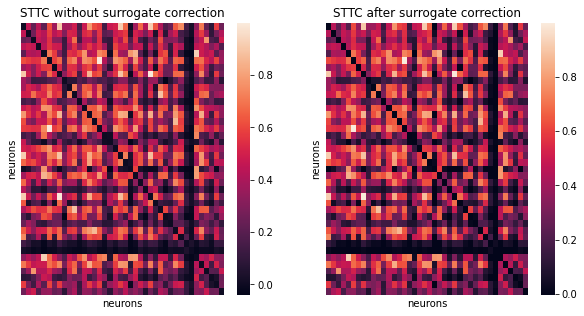

In [11]:
# plot 

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
sns.heatmap(STTC_FC_mat['raw_sttc_mat'], ax=ax1)
ax1.set_title('STTC without surrogate correction')
ax1.set_xlabel('neurons')
ax1.set_ylabel('neurons')
plt.xticks([]),plt.yticks([])

ax2 = fig.add_subplot(122)
sns.heatmap(STTC_FC_mat['eff_sttc_mat'], ax=ax2)
ax2.set_title('STTC after surrogate correction')
ax2.set_xlabel('neurons')
ax2.set_ylabel('neurons')
plt.xticks([]),plt.yticks([])

## 3. derive functional connectivity using cross-correlation histograms (CCHs)

In [38]:
# load physical location, this location information will be used for filtering spurious connections out.
elec_loc = np.load('../data/example_locs.npy')
print(elec_loc) # unit = um.
print(elec_loc.shape)

[[1435.   577.5]
 [1435.   542.5]
 [2135.   437.5]
 [1645.   752.5]
 [1050.   892.5]
 [1470.   507.5]
 [1365.   612.5]
 [1085.   542.5]
 [1085.   402.5]
 [1225.   577.5]
 [1925.   717.5]
 [1925.   717.5]
 [1225.  1067.5]
 [1610.   682.5]
 [1610.   682.5]
 [1575.   402.5]
 [1400.   857.5]
 [1470.   437.5]
 [1470.   437.5]
 [1260.   507.5]
 [1785.   402.5]
 [2205.   542.5]
 [1995.   857.5]
 [1680.   752.5]
 [1295.   367.5]
 [1225.   437.5]
 [1260.   402.5]
 [1785.   577.5]
 [1925.  1067.5]
 [1925.   612.5]
 [1365.   787.5]
 [1435.   577.5]
 [1855.   402.5]
 [2205.   367.5]
 [1505.   717.5]
 [1575.   367.5]
 [2205.   892.5]
 [1960.  1067.5]
 [1435.   542.5]
 [2135.   892.5]]
(40, 2)


In [37]:
# compute CCH derived directed functional connectivity (adapted Pastore et al. 2018, https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006381)
sensitivity_vec = [1, 0.5, 0] # here we use 3 different levels of sensitivity

sens_results = []
for sens in sensitivity_vec:
    sens_results.append(spkclass.compute_fncch_connectivity(elec_loc, sens, binsize=1, n_cpu=16)) #binsize=1 here corresponds to 1 ms. bin for generating binned spike trains

100%|██████████| 780/780 [00:48<00:00, 15.93it/s]

num of connected components :1
density of vanilla graph :0.0641025641025641
used sensitivity : 1



100%|██████████| 780/780 [00:49<00:00, 15.81it/s]


num of connected components :1
density of vanilla graph :0.11666666666666667
used sensitivity : 0.5


100%|██████████| 780/780 [00:49<00:00, 15.89it/s]

num of connected components :1
density of vanilla graph :0.3141025641025641
used sensitivity : 0


For this example, already with the highest sensitivity value, 1, we get only one connected component (component size >=2)

In [39]:
# There are a lot of information stored for CCH FCs 
print(sens_results[0].keys())
CCH_result = sens_results[0] #let us focus on the result using the highest sensitivity 


# keys description
# intermediate results without any spurious connection filtering
# 'ex_in_mat_raw' : matrix with each entry showing excitatory(+1), inhibitory(-1), no connection (0). Reflects solely the existence of peaks and troughs in CCHs
# 'weight_raw' : as a coupled matrix for 'ex_in_mat_raw', stores absolute magnitude of peaks/troughs
# 'lag_mat' : a matrix that stores the time bin of when(bin) a peak/trough happened for that edge.

# after filtering using axonal propagation density
# 'ex_in_mat_after_prop': 'ex_in_mat_raw' after deleting edges that were not valid given the propagation delay. 
# 'raw_after_prop' : 'weight_raw' after deleting weights that were not valid given the propagation delay. 

# applied peer based thresholding
# 'ex_in_mat': using entries in 'ex_in_mat_after_prop', peer-based thresholding was done.
# 'final_weight_mat': matching 'raw_after_prop' for 'ex_in_mat', after peer-based thresholding.
# 'sensitivity': used sensitivity level


# after applying dale's law 
# 'dale_mat_raw' : corresponds to 'ex_in_mat_after_prop' after applying dale's law (cell can be only excitatory or inhibitory not both at once.)
# 'dale_mat' : dale's law applied to 'ex_in_mat'
# 'dale_weight' : dale's law applied to 'final_weight_mat'



# we focus on two keys
# 'comp_sizes' returns sizes of components in the graph
# 'comps_viable' returns a number of components that are greater than 2 
# 'con_density' returns connection density of the graph (converted to undirected graph)

dict_keys(['ex_in_mat_raw', 'raw_after_prop', 'weight_raw', 'ex_in_mat_after_prop', 'final_weight_mat', 'lag_mat', 'ex_in_mat', 'sensitivity', 'dale_mat', 'dale_mat_raw', 'dale_weight', 'con_density', 'comps_viable', 'comp_sizes'])


In [40]:
CCH_result['comp_sizes'] # however, as we can see here, there are a lot of disconnected neurons

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 24,  1,  1,  1])

(([], []), ([], []))

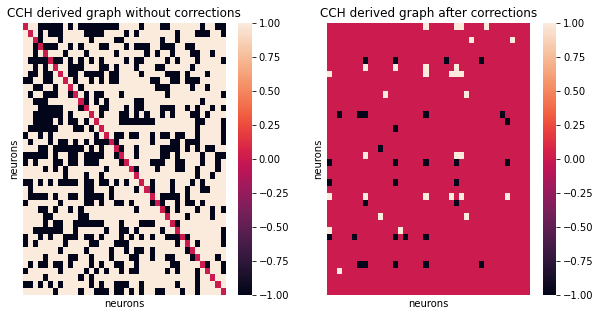

In [41]:
# plot 

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
sns.heatmap(CCH_result['ex_in_mat_raw'], ax=ax1)
ax1.set_title('CCH derived graph without corrections')
ax1.set_xlabel('neurons')
ax1.set_ylabel('neurons')
plt.xticks([]),plt.yticks([])

ax2 = fig.add_subplot(122)
sns.heatmap(CCH_result['dale_mat'], ax=ax2)
ax2.set_title('CCH derived graph after corrections')
ax2.set_xlabel('neurons')
ax2.set_ylabel('neurons')
plt.xticks([]),plt.yticks([])

As we can see from these two heatmaps, pre-post (row - column) relation now has only one type of connection (excitatory vs inhibitory) 